In [1]:
import numpy as np
import pandas as pd


import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer


from tqdm import tqdm
import os, re, csv, math, codecs

Using TensorFlow backend.


In [2]:

print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('model_new.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


36084it [00:01, 18968.87it/s]


found 36084 word vectors


In [3]:
train_df = pd.read_csv('final_train.csv')
test_df = pd.read_csv('final_test.csv')


print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

num train:  17433
num test:  7350


In [4]:
class_label=['class']
y_train = train_df[class_label].values
y_test = test_df[class_label].values


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 


stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

MAX_NB_WORDS = len(embeddings_index)
tokenizer = RegexpTokenizer(r'\w+')
raw_docs_train = train_df['clean_tweet'].tolist()
raw_docs_test = test_df['clean_tweet'].tolist() 
num_classes = len(class_label)
print(num_classes)
print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))


print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))



#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=100)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=100)



1
pre-processing train data...


100%|██████████████████████████████████████████████████████████████████████████| 7350/7350 [00:00<00:00, 133768.41it/s]


tokenizing input data...
dictionary size:  22505


In [6]:
num_words = len(word_index) + 1
embedd = np.zeros((num_words,100))

for word , i in word_index.items():
    if i > num_words:
        continue
    embedd_vec = embeddings_index.get(word)
    if embedd_vec is not None:
        embedd[i] = embedd_vec     
print(num_words)

22506


In [7]:
#training params
batch_size = 64 
num_epochs = 10

#model parameters
num_filters = 64 
embed_dim = 100 


In [8]:
print("training CNN ...")
model = Sequential()
model.add(Embedding(num_words, embed_dim,
          weights=[embedd], input_length=100, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='relu'))  

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

training CNN ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2250600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            28736     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 64)            28736     
_________________________________________________________________
conv

In [9]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(word_seq_test, y_test), verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 17433 samples, validate on 7350 samples
Epoch 1/10
 - 15s - loss: 0.1649 - acc: 0.8359 - val_loss: 0.0856 - val_acc: 0.8955
Epoch 2/10
 - 14s - loss: 0.1162 - acc: 0.8790 - val_loss: 0.0804 - val_acc: 0.9090
Epoch 3/10
 - 14s - loss: 0.1079 - acc: 0.8885 - val_loss: 0.0769 - val_acc: 0.9127
Epoch 4/10
 - 14s - loss: 0.1012 - acc: 0.8923 - val_loss: 0.0920 - val_acc: 0.8978
Epoch 5/10
 - 14s - loss: 0.0967 - acc: 0.8983 - val_loss: 0.0780 - val_acc: 0.9122
Epoch 6/10
 - 14s - loss: 0.0925 - acc: 0.9013 - val_loss: 0.0735 - val_acc: 0.9151
Epoch 7/10
 - 14s - loss: 0.0875 - acc: 0.9050 - val_loss: 0.0715 - val_acc: 0.9190
Epoch 8/10
 - 14s - loss: 0.0846 - acc: 0.9070 - val_loss: 0.0893 - val_acc: 0.8961
Epoch 9/10
 - 14s - loss: 0.0818 - acc: 0.9081 - val_loss: 0.0724 - val_acc: 0.9143
Epoch 10/10
 - 14s - loss: 0.0796 - acc: 0.9115 - val_loss: 0.0686 - 

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9245
Testing Accuracy:  0.9212


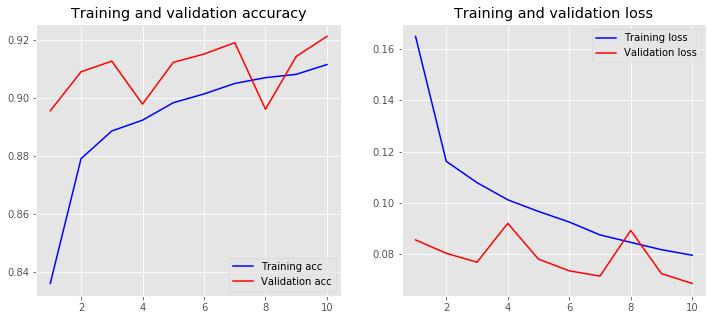

In [11]:
loss, accuracy = model.evaluate(word_seq_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(word_seq_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(hist)

In [21]:
from sklearn import metrics

y_pred = model.predict(word_seq_test)

y_pred = y_pred.round()

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

cp = metrics.classification_report(y_test, y_pred, digits=3)



# Print the precision and recall, among other metrics
print(cp)



[[ 118  282   13]
 [  44 5486  116]
 [   0  124 1167]]
              precision    recall  f1-score   support

           0      0.728     0.286     0.410       413
           1      0.931     0.972     0.951      5646
           2      0.900     0.904     0.902      1291

   micro avg      0.921     0.921     0.921      7350
   macro avg      0.853     0.720     0.755      7350
weighted avg      0.914     0.921     0.912      7350



NameError: name 'plot_classification_report' is not defined

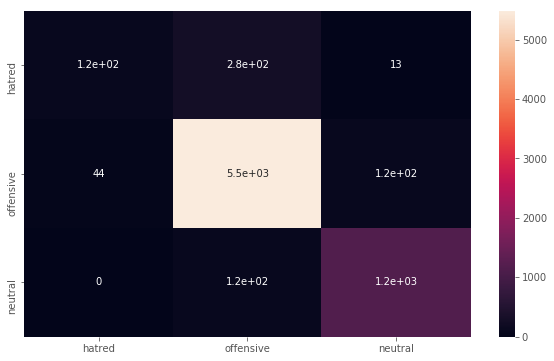

In [13]:
import seaborn as sns

index = ['hatred','offensive','neutral']
columns = ['hatred','offensive','neutral']

cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)


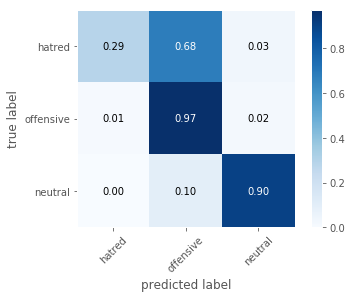

In [14]:
from mlxtend.plotting import plot_confusion_matrix

class_names = ['hatred','offensive','neutral']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names)
plt.show()

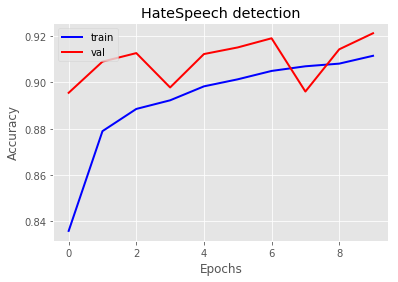

In [15]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('HateSpeech detection')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [16]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

print(accuracy)
print(misclass)

0.9212244897959184
0.07877551020408158


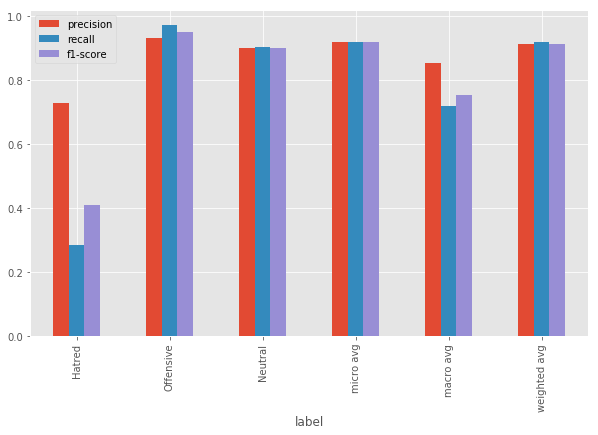

In [37]:
import pandas as pd

report_data = []

for label, metrics in classification_report(y_test,y_pred, output_dict=True).items():
    if label=="0":
        label = "Hatred"
    if label=="1":
        label = "Offensive"
    if label=="2":
        label = "Neutral"
    
    metrics['label'] = label
    report_data.append(metrics)

report_df = pd.DataFrame(
    report_data, 
    columns=['label', 'precision', 'recall', 'f1-score', 'support']
)

# Plot as a bar chart.
report_df.plot(y=['precision', 'recall', 'f1-score'], x='label', kind='bar',figsize=(10,6))